In [78]:
# Packages for data 
import pandas as pd
import numpy as np
import pickle
from collections import Counter

# Packages for machine learning modelling
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# precision_score, recall_score, f1_score

from sklearn_pandas import DataFrameMapper
# from sklearn.pipeline import Pipeline
# from sklearn.pipeline import FeatureUnion

# Packages for sentiment analysis
from textblob import TextBlob


# Packages for visualisation 
import matplotlib.pyplot as plt

# Packages for NLP
import nltk

from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt

# Reading the data

In [3]:
train_data = pd.read_csv("../Data/Combined data/train_data.csv", index_col=1)
val_data = pd.read_csv("../Data/Combined data/val_data.csv", index_col=1)
test_data = pd.read_csv("../Data/Combined data/test_data.csv", index_col=1)

In [4]:
X_train_text = train_data["text_preprocessed"].values
y_train = train_data["class_label"].values

X_val_text = val_data["text_preprocessed"].values
y_val = val_data["class_label"].values

X_test_text = test_data["text_preprocessed"].values
y_test = test_data["class_label"].values

# Creating the Base Model using Naive Bayes

## Using CountVectorizer

In [14]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,1))
vectorizer.fit(X_train_text)

X_train = vectorizer.transform(X_train_text)
X_val = vectorizer.transform(X_val_text)
X_test = vectorizer.transform(X_test_text)

In [27]:
print("number of features used:", len(vectorizer.get_feature_names()))

number of features used: 238266


In [29]:
# Sparse vector of frequency of each word appearing in a text article
print(type(X_train))

<class 'scipy.sparse.csr.csr_matrix'>


In [20]:
naive_bayes_clf = BernoulliNB()
naive_bayes_clf.fit(X_train, y_train)

BernoulliNB()

In [28]:
count_vectorizer_params = {'unigram':(1,1), 'unigram and bigram': (1,2), 'bigram':(2,2)}

for ngram, values in count_vectorizer_params.items():
    vectorizer = CountVectorizer(stop_words='english', ngram_range=values)
    vectorizer.fit(X_train_text)

    X_train = vectorizer.transform(X_train_text)
    X_val = vectorizer.transform(X_val_text)
    X_test = vectorizer.transform(X_test_text)

    print(f'CountVectorizer Model with {ngram}')
    naive_bayes_clf.fit(X_train, y_train)

    #Validation Data
    print('Testing with validation data:')
    val_pred = naive_bayes_clf.predict(X_val)
    print(classification_report(y_val, val_pred))
    print("------------------------------------------")

    # Test Data
    print('Testing using test data:')
    test_pred = naive_bayes_clf.predict(X_test)
    print(classification_report(y_test, test_pred))
    print("------------------------------------------")
    print("------------------------------------------")

CountVectorizer Model with unigram
Testing with validation data:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      6361
           1       0.90      0.89      0.90      6659

    accuracy                           0.90     13020
   macro avg       0.90      0.90      0.90     13020
weighted avg       0.90      0.90      0.90     13020

------------------------------------------
Testing using test data:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6361
           1       0.90      0.91      0.91      6660

    accuracy                           0.90     13021
   macro avg       0.90      0.90      0.90     13021
weighted avg       0.90      0.90      0.90     13021

------------------------------------------
------------------------------------------
CountVectorizer Model with unigram and bigram
Testing with validation data:
              precision    recall  f1-score   suppo

## Using Tf-Idf

In [25]:
tfidf_params = {'unigram':(1,1), 'unigram and bigram': (1,2), 'bigram':(2,2)}

for ngram, values in tfidf_params.items():
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=values)
    tfidf_vectorizer.fit(X_train_text)

    X_train = tfidf_vectorizer.transform(X_train_text)
    X_val = tfidf_vectorizer.transform(X_val_text)
    X_test = tfidf_vectorizer.transform(X_test_text)

    naive_bayes_clf = BernoulliNB()
    print(f"Model with {ngram}")
    naive_bayes_clf.fit(X_train, y_train)

    # Validation Data
    print("Testing using validation data:")    
    y_val_pred = naive_bayes_clf.predict(X_val)
    print(classification_report(y_val, y_val_pred))
    print("------------------------------------------")

    # Test Data
    print("Testing using test data:")
    y_test_pred = naive_bayes_clf.predict(X_test)
    print(classification_report(y_test, y_test_pred))
    print("------------------------------------------")
    print("------------------------------------------")

Model with unigram
Testing using validation data:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      6361
           1       0.90      0.89      0.90      6659

    accuracy                           0.90     13020
   macro avg       0.90      0.90      0.90     13020
weighted avg       0.90      0.90      0.90     13020

------------------------------------------
Testing using test data:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6361
           1       0.90      0.91      0.91      6660

    accuracy                           0.90     13021
   macro avg       0.90      0.90      0.90     13021
weighted avg       0.90      0.90      0.90     13021

------------------------------------------
------------------------------------------
Model with unigram and bigram
Testing using validation data:
              precision    recall  f1-score   support

           0       0.95   

# Feature Selection

In [72]:
def get_weighted_average(report):
    '''
    Takes in a classification report object and returns the weighted average precision, recall and f1 score.
    '''
    lines = report.split('\n')
    lines2 = lines[7].split('   ')
    # print(lines2)
    precision = float(lines2[2][1:])
    recall = float(lines2[4])
    f1score = float(lines2[6])
    # print('-->', precision)
    # print('-->', recall)
    # print('-->', f1score)
    return precision, recall, f1score

In [73]:
min_threshold_config = [0.0, 0.05, 0.1, 0.15, 0.2]
max_threshold_config = [0.8, 0.85, 0.9, 0.95, 1.0]

# Create lists to save values for plotting later
countvectorizer_numfeatures = []
countvectorizer_precision = []
countvectorizer_recall = []
countvectorizer_f1score = []

tfidf_numfeatures = []
tfidf_precision = []
tfidf_recall = []
tfidf_f1score = []

## CountVectorizer

### Try 1 with various configurations

In [34]:
for min_value in min_threshold_config:
    print('--------------------CountVectorizer--------------------')
    for max_value in max_threshold_config:
        vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=min_value, max_df=max_value)
        vectorizer.fit(X_train_text)

        X_train = vectorizer.transform(X_train_text)
        X_val = vectorizer.transform(X_val_text)
        X_test = vectorizer.transform(X_test_text)

        print(f'CountVectorizer Model with min_df={min_value}, max_df={max_value}')
        naive_bayes_clf.fit(X_train, y_train)
        print(len(vectorizer.get_feature_names()))
        
        # #Validation Data
        # print('Testing with validation data:')
        # val_pred = naive_bayes_clf.predict(X_val)
        # print(classification_report(y_val, val_pred))
        # print("------------------------------------------")

        # Test Data
        print('Testing using test data:')
        test_pred = naive_bayes_clf.predict(X_test)
        print(classification_report(y_test, test_pred))
        print("------------------------------------------")
        print("------------------------------------------")

--------------------CountVectorizer--------------------
CountVectorizer Model with min_df=0.0, max_df=0.8
4540301
Testing using test data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6361
           1       0.89      0.96      0.92      6660

    accuracy                           0.92     13021
   macro avg       0.92      0.92      0.92     13021
weighted avg       0.92      0.92      0.92     13021

------------------------------------------
------------------------------------------
CountVectorizer Model with min_df=0.0, max_df=0.85
4540301
Testing using test data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6361
           1       0.89      0.96      0.92      6660

    accuracy                           0.92     13021
   macro avg       0.92      0.92      0.92     13021
weighted avg       0.92      0.92      0.92     13021

-------------------------------------

### Try 2 with min_df only in smaller increments of 0.01

In [76]:
values = [x * 0.01 for x in range(0, 16)]

print('--------------------CountVectorizer--------------------')
for min_value in values:
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=min_value)
    vectorizer.fit(X_train_text)

    X_train = vectorizer.transform(X_train_text)
    # X_val = vectorizer.transform(X_val_text)
    X_test = vectorizer.transform(X_test_text)

    print(f'CountVectorizer Model with min_df={min_value}')
    naive_bayes_clf.fit(X_train, y_train)
    num_features = len(vectorizer.get_feature_names())
    print(num_features)
    countvectorizer_numfeatures.append(num_features)

    # #Validation Data
    # print('Testing with validation data:')
    # val_pred = naive_bayes_clf.predict(X_val)
    # print(classification_report(y_val, val_pred))
    # print("------------------------------------------")

    # Test Data
    print('Testing using test data:')
    test_pred = naive_bayes_clf.predict(X_test)
    report = classification_report(y_test, test_pred)
    print(report)
    print("------------------------------------------")
    print("------------------------------------------")

    precision, recall, f1score = get_weighted_average(report)
    countvectorizer_precision.append(precision)
    countvectorizer_recall.append(recall)
    countvectorizer_f1score.append(f1score)

--------------------CountVectorizer--------------------
CountVectorizer Model with min_df=0.0


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


4540301
Testing using test data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6361
           1       0.89      0.96      0.92      6660

    accuracy                           0.92     13021
   macro avg       0.92      0.92      0.92     13021
weighted avg       0.92      0.92      0.92     13021

------------------------------------------
------------------------------------------
CountVectorizer Model with min_df=0.01
3373
Testing using test data:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      6361
           1       0.83      0.90      0.86      6660

    accuracy                           0.85     13021
   macro avg       0.86      0.85      0.85     13021
weighted avg       0.86      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.02
1923
Testing using test data:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      6361
           1       0.83      0.88      0.85      6660

    accuracy                           0.84     13021
   macro avg       0.85      0.84      0.84     13021
weighted avg       0.85      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.03
1330
Testing using test data:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      6361
           1       0.82      0.87      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.83      0.83     13021
weighted avg       0.84      0.84      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.04
1042
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      6361
           1       0.82      0.87      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.05
818
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      6361
           1       0.81      0.86      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.06
649
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      6361
           1       0.82      0.86      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.07
525
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      6361
           1       0.82      0.85      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.08
435
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      6361
           1       0.82      0.85      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.09
374
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6361
           1       0.83      0.85      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.1
316
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6361
           1       0.83      0.85      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.11
269
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6361
           1       0.84      0.85      0.85      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.12
226
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6361
           1       0.84      0.84      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.13
198
Testing using test data:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      6361
           1       0.85      0.84      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.14
169
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      6361
           1       0.85      0.85      0.85      6660

    accuracy                           0.85     13021
   macro avg       0.85      0.85      0.85     13021
weighted avg       0.85      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CountVectorizer Model with min_df=0.15
134
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6361
           1       0.86      0.85      0.86      6660

    accuracy                           0.85     13021
   macro avg       0.85      0.85      0.85     13021
weighted avg       0.85      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## TF-IDF

### Try 1 with various configurations

In [11]:
# Try 1
print('--------------------TF-IDF--------------------')
for min_value in min_threshold_config:
    for max_value in max_threshold_config:
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=min_value) #, max_df=max_value
        tfidf_vectorizer.fit(X_train_text)

        X_train = tfidf_vectorizer.transform(X_train_text)
        # X_val = tfidf_vectorizer.transform(X_val_text)
        X_test = tfidf_vectorizer.transform(X_test_text)

        print(f'TF-IDF Model with min_df={min_value}') #, max_df={max_value}
        naive_bayes_clf.fit(X_train, y_train)
        print(len(tfidf_vectorizer.get_feature_names()))

        # #Validation Data
        # print('Testing with validation data:')
        # val_pred = naive_bayes_clf.predict(X_val)
        # print(classification_report(y_val, val_pred))
        # print("------------------------------------------")

        # Test Data
        print('Testing using test data:')
        test_pred = naive_bayes_clf.predict(X_test)
        print(classification_report(y_test, test_pred))
        print("------------------------------------------")
        print("------------------------------------------")

--------------------TF-IDF--------------------
TF-IDF Model with min_df=0.0


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


4540301
Testing using test data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6361
           1       0.89      0.96      0.92      6660

    accuracy                           0.92     13021
   macro avg       0.92      0.92      0.92     13021
weighted avg       0.92      0.92      0.92     13021

------------------------------------------
------------------------------------------
TF-IDF Model with min_df=0.0


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


4540301
Testing using test data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6361
           1       0.89      0.96      0.92      6660

    accuracy                           0.92     13021
   macro avg       0.92      0.92      0.92     13021
weighted avg       0.92      0.92      0.92     13021

------------------------------------------
------------------------------------------
TF-IDF Model with min_df=0.0


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


4540301
Testing using test data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6361
           1       0.89      0.96      0.92      6660

    accuracy                           0.92     13021
   macro avg       0.92      0.92      0.92     13021
weighted avg       0.92      0.92      0.92     13021

------------------------------------------
------------------------------------------
TF-IDF Model with min_df=0.0


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


4540301
Testing using test data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6361
           1       0.89      0.96      0.92      6660

    accuracy                           0.92     13021
   macro avg       0.92      0.92      0.92     13021
weighted avg       0.92      0.92      0.92     13021

------------------------------------------
------------------------------------------
TF-IDF Model with min_df=0.0


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


4540301
Testing using test data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6361
           1       0.89      0.96      0.92      6660

    accuracy                           0.92     13021
   macro avg       0.92      0.92      0.92     13021
weighted avg       0.92      0.92      0.92     13021

------------------------------------------
------------------------------------------
TF-IDF Model with min_df=0.05
818
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      6361
           1       0.81      0.86      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.05
818
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      6361
           1       0.81      0.86      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.05
818
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      6361
           1       0.81      0.86      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.05
818
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      6361
           1       0.81      0.86      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.05
818
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      6361
           1       0.81      0.86      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.1
316
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6361
           1       0.83      0.85      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.1
316
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6361
           1       0.83      0.85      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.1
316
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6361
           1       0.83      0.85      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.1
316
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6361
           1       0.83      0.85      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.1
316
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6361
           1       0.83      0.85      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.15
134
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6361
           1       0.86      0.85      0.86      6660

    accuracy                           0.85     13021
   macro avg       0.85      0.85      0.85     13021
weighted avg       0.85      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.15
134
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6361
           1       0.86      0.85      0.86      6660

    accuracy                           0.85     13021
   macro avg       0.85      0.85      0.85     13021
weighted avg       0.85      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.15
134
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6361
           1       0.86      0.85      0.86      6660

    accuracy                           0.85     13021
   macro avg       0.85      0.85      0.85     13021
weighted avg       0.85      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.15
134
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6361
           1       0.86      0.85      0.86      6660

    accuracy                           0.85     13021
   macro avg       0.85      0.85      0.85     13021
weighted avg       0.85      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.15
134
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6361
           1       0.86      0.85      0.86      6660

    accuracy                           0.85     13021
   macro avg       0.85      0.85      0.85     13021
weighted avg       0.85      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.2
73
Testing using test data:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      6361
           1       0.85      0.82      0.83      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.2
73
Testing using test data:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      6361
           1       0.85      0.82      0.83      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.2
73
Testing using test data:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      6361
           1       0.85      0.82      0.83      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.2
73
Testing using test data:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      6361
           1       0.85      0.82      0.83      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.2
73
Testing using test data:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      6361
           1       0.85      0.82      0.83      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Try 2 with min_df only in smaller increments of 0.01

In [77]:
print('--------------------TF-IDF--------------------')
for min_value in values:
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=min_value)
    tfidf_vectorizer.fit(X_train_text)

    X_train = tfidf_vectorizer.transform(X_train_text)
    # X_val = tfidf_vectorizer.transform(X_val_text)
    X_test = tfidf_vectorizer.transform(X_test_text)

    print(f'TF-IDF Model with min_df={min_value}')
    naive_bayes_clf.fit(X_train, y_train)
    num_features = len(tfidf_vectorizer.get_feature_names())
    print(num_features)
    tfidf_numfeatures.append(num_features)

    # #Validation Data
    # print('Testing with validation data:')
    # val_pred = naive_bayes_clf.predict(X_val)
    # print(classification_report(y_val, val_pred))
    # print("------------------------------------------")

    # Test Data
    print('Testing using test data:')
    test_pred = naive_bayes_clf.predict(X_test)
    report = classification_report(y_test, test_pred)
    print(report)
    print("------------------------------------------")
    print("------------------------------------------")

    precision, recall, f1score = get_weighted_average(report)
    tfidf_precision.append(precision)
    tfidf_recall.append(recall)
    tfidf_f1score.append(f1score)


--------------------TF-IDF--------------------
TF-IDF Model with min_df=0.0


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


4540301
Testing using test data:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6361
           1       0.89      0.96      0.92      6660

    accuracy                           0.92     13021
   macro avg       0.92      0.92      0.92     13021
weighted avg       0.92      0.92      0.92     13021

------------------------------------------
------------------------------------------
TF-IDF Model with min_df=0.01
3373
Testing using test data:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      6361
           1       0.83      0.90      0.86      6660

    accuracy                           0.85     13021
   macro avg       0.86      0.85      0.85     13021
weighted avg       0.86      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.02
1923
Testing using test data:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      6361
           1       0.83      0.88      0.85      6660

    accuracy                           0.84     13021
   macro avg       0.85      0.84      0.84     13021
weighted avg       0.85      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.03
1330
Testing using test data:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      6361
           1       0.82      0.87      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.83      0.83     13021
weighted avg       0.84      0.84      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.04
1042
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      6361
           1       0.82      0.87      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.05
818
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      6361
           1       0.81      0.86      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.06
649
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      6361
           1       0.82      0.86      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.07
525
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      6361
           1       0.82      0.85      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.08
435
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      6361
           1       0.82      0.85      0.84      6660

    accuracy                           0.83     13021
   macro avg       0.83      0.83      0.83     13021
weighted avg       0.83      0.83      0.83     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.09
374
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6361
           1       0.83      0.85      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.1
316
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6361
           1       0.83      0.85      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.11
269
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6361
           1       0.84      0.85      0.85      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.12
226
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6361
           1       0.84      0.84      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.13
198
Testing using test data:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      6361
           1       0.85      0.84      0.84      6660

    accuracy                           0.84     13021
   macro avg       0.84      0.84      0.84     13021
weighted avg       0.84      0.84      0.84     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.14
169
Testing using test data:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      6361
           1       0.85      0.85      0.85      6660

    accuracy                           0.85     13021
   macro avg       0.85      0.85      0.85     13021
weighted avg       0.85      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF Model with min_df=0.15
134
Testing using test data:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6361
           1       0.86      0.85      0.86      6660

    accuracy                           0.85     13021
   macro avg       0.85      0.85      0.85     13021
weighted avg       0.85      0.85      0.85     13021

------------------------------------------
------------------------------------------


/Users/joshuawong/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Tuning max_features instead

In [47]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=10000) #, max_df=max_value
tfidf_vectorizer.fit(X_train_text)

X_train = tfidf_vectorizer.transform(X_train_text)
X_val = tfidf_vectorizer.transform(X_val_text)
X_test = tfidf_vectorizer.transform(X_test_text)

print(f'TF-IDF Model with min_df={min_value}') #, max_df={max_value}
naive_bayes_clf.fit(X_train, y_train)
print(len(tfidf_vectorizer.get_feature_names()))

# #Validation Data
# print('Testing with validation data:')
# val_pred = naive_bayes_clf.predict(X_val)
# print(classification_report(y_val, val_pred))
# print("------------------------------------------")

# Test Data
print('Testing using test data:')
test_pred = naive_bayes_clf.predict(X_test)
print(classification_report(y_test, test_pred))
print("------------------------------------------")
print("------------------------------------------")

TF-IDF Model with min_df=0.2
10000
Testing using test data:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      6361
           1       0.86      0.92      0.89      6660

    accuracy                           0.88     13021
   macro avg       0.88      0.88      0.88     13021
weighted avg       0.88      0.88      0.88     13021

------------------------------------------
------------------------------------------


### Finding out which words were eliminated and kept

In [18]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.01)
tfidf_vectorizer.fit(X_train_text)
list1 = list(tfidf_vectorizer.get_feature_names_out())
print(list(tfidf_vectorizer.get_feature_names_out()))

['000', '10', '10 percent', '10 year', '100', '1000', '10000', '100000', '11', '12', '13', '14', '15', '150', '16', '17', '18', '19', '1960', '1970', '1980', '1990', '20', '20 percent', '20 year', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2016 elect', '2016 presidenti', '2017', '2018', '2019', '2020', '21', '21st', '21st centuri', '21wire', '21wiretv', '22', '23', '24', '25', '26', '27', '28', '29', '30', '300', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '400', '41', '42', '43', '44', '45', '46', '48', '49', '50', '500', '51', '52', '55', '60', '600', '65', '70', '75', '80', '800', '90', '911', 'abandon', 'abc', 'abil', 'abl', 'abort', 'abroad', 'absenc', 'absolut', 'absurd', 'abus', 'academ', 'academi', 'acceler', 'accept', 'access', 'accid', 'accompani', 'accomplish', 'accord', 'accord report', 'account', 'accur', 'accus', 'achiev', 'acknowledg', 'acquir', 'act', 'ac

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.00)
tfidf_vectorizer.fit(X_train_text)
list2 = list(tfidf_vectorizer.get_feature_names_out())

In [27]:
unique = set(list2) - set(list1)
print(len(list(unique)))
print(list(unique)[:1000])

4536928
['courtney ct', 'campaign barr', 'iraq militia', 'space sanction', 'coalit esquerra', 'remain messag', 'subsid support', 'best wednesday', 'union manag', 'трудности получении', 'charact mr', 'peopl render', 'veteran problem', 'полки конечно', 'aka stan', 'relat council', 'previous nonpartisan', 'librarian historian', 'inform exoner', 'market million', 'manufactur capac', 'unless door', 'carri signatur', 'batshit craze', 'stagger 85', 'conversationsnytim convers', 'inform perspectivebi', 'interview heredwyan', 'talon', 'write thorough', 'lunchth problem', 'respect arm', 'state univis', 'ago modi', 'audiencemckinnon agre', '1000000000000000 debt', 'realist partner', 'switzerland recent', 'propos virtual', 'got ashcan', 'come option', 'world nuke', 'yard plagu', 'visit mommi', 'afoot pass', 'die foundat', 'frank sharri', 'justic hate', 'postmodern swept', 'oligarchi desir', 'clinton novic', 'relat section', 'carli fiorinafox', 'advoc terrorist', 'ban saudiown', 'throw batch', 'ial

In [123]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.15)
tfidf_vectorizer.fit(X_train_text)
list3 = list(tfidf_vectorizer.get_feature_names_out())
print(len(list3))
print(list3)

134
['2016', 'accord', 'act', 'ad', 'administr', 'allow', 'america', 'american', 'anoth', 'appear', 'ask', 'attack', 'becom', 'believ', 'campaign', 'case', 'chang', 'citi', 'claim', 'clinton', 'close', 'come', 'comment', 'continu', 'countri', 'critic', 'day', 'democrat', 'donald', 'donald trump', 'elect', 'end', 'everi', 'face', 'fact', 'feder', 'follow', 'forc', 'gener', 'good', 'govern', 'group', 'happen', 'help', 'hillari', 'hillari clinton', 'hous', 'imag', 'includ', 'issu', 'know', 'law', 'lead', 'leader', 'live', 'long', 'look', 'major', 'make', 'mani', 'mean', 'media', 'meet', 'member', 'million', 'month', 'nation', 'need', 'new', 'new york', 'news', 'number', 'obama', 'offic', 'offici', 'order', 'parti', 'peopl', 'person', 'place', 'plan', 'point', 'polici', 'polit', 'possibl', 'post', 'power', 'presid', 'presidenti', 'public', 'question', 'realli', 'recent', 'report', 'repres', 'republican', 'respons', 'reuter', 'right', 'run', 'said', 'say', 'secur', 'senat', 'sever', 'start'

# Feature Selection Plots

## Countvectorizer

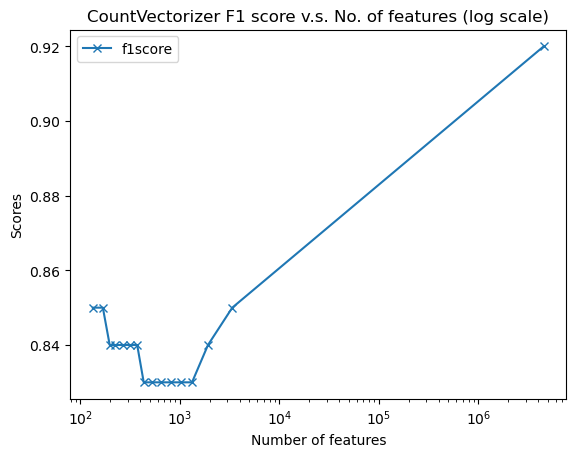

In [120]:
# countvectorizer
plt.plot(countvectorizer_numfeatures, countvectorizer_f1score, label = "f1score", marker='x')
# plt.plot(countvectorizer_numfeatures, countvectorizer_precision, label = "precision", marker='o')
# plt.plot(countvectorizer_numfeatures, countvectorizer_recall, label = "recall", marker='^')
plt.xscale('log')
plt.title('CountVectorizer F1 score v.s. No. of features (log scale)')
plt.xlabel('Number of features')
plt.ylabel('Scores')
plt.legend()
plt.show()

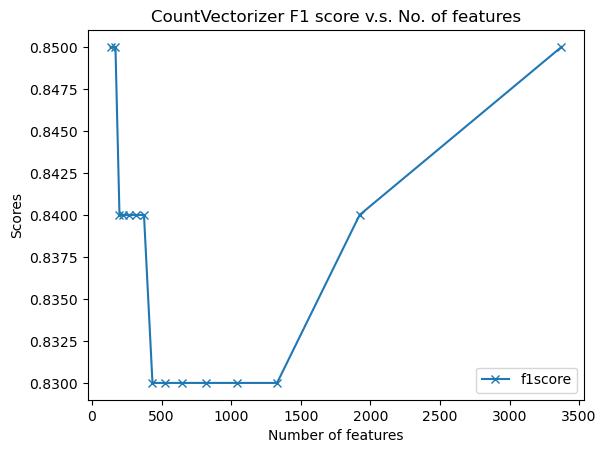

In [119]:
plt.plot(countvectorizer_numfeatures[1:], countvectorizer_f1score[1:], label = "f1score", marker='x')
# plt.plot(countvectorizer_numfeatures[1:], countvectorizer_precision[1:], label = "precision", marker='o')
# plt.plot(countvectorizer_numfeatures[1:], countvectorizer_recall[1:], label = "recall", marker='^')
plt.title('CountVectorizer F1 score v.s. No. of features')
plt.xlabel('Number of features')
plt.ylabel('Scores')
plt.legend()
plt.show()

## TFIDF

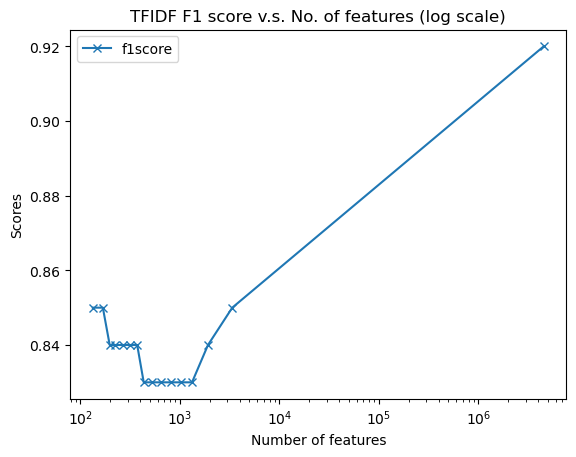

In [121]:
# TFIDF
plt.plot(tfidf_numfeatures, tfidf_f1score, label = "f1score", marker='x')
# plt.plot(tfidf_numfeatures, tfidf_precision, label = "precision", marker='o')
# plt.plot(tfidf_numfeatures, tfidf_recall, label = "recall", marker='^')
plt.xscale('log')
plt.title('TFIDF F1 score v.s. No. of features (log scale)')
plt.xlabel('Number of features')
plt.ylabel('Scores')
plt.legend()
plt.show()

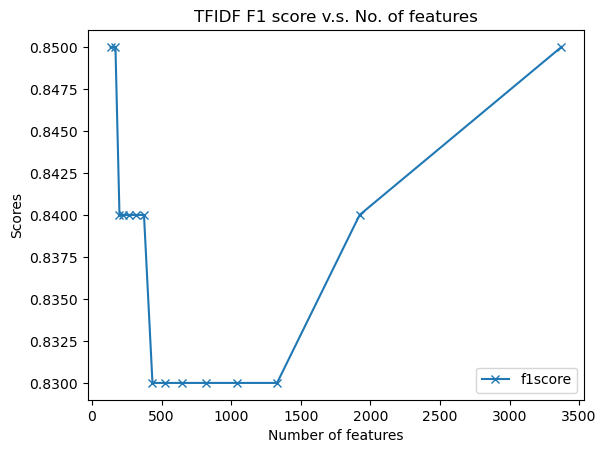

In [122]:
plt.plot(tfidf_numfeatures[1:], tfidf_f1score[1:], label = "f1score", marker='x')
# plt.plot(tfidf_numfeatures[1:], tfidf_precision[1:], label = "precision", marker='o')
# plt.plot(tfidf_numfeatures[1:], tfidf_recall[1:], label = "recall", marker='^')
plt.title('TFIDF F1 score v.s. No. of features')
plt.xlabel('Number of features')
plt.ylabel('Scores')
plt.legend()
plt.show()

# TruncatedSVD

Explanation for reference: https://vitalv.github.io/projects/doc-clustering-topic-modeling.html

In [ ]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [1500] # 4,10,15,20,50,100,150,200,500,700,800,900,1000,1500,2000,2500,3000,3500 list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_train)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

# svd = TruncatedSVD(n_components=5, n_iter=7, random_state=424)
# svd.fit(X_train)

# print(svd.explained_variance_ratio_)

In [ ]:
truncatedSVD = TruncatedSVD(n_components=1000)
X_truncated = truncatedSVD.fit_transform(X_train)

X_test_truncated = truncatedSVD.fit_transform(X_test)

In [ ]:
naive_bayes_clf.fit(X_truncated, y_train)

y_pred = naive_bayes_clf.predict(X_test_truncated)
print(classification_report(y_test, y_pred))

# Feature Selection for Additional Features

## Re-evaluating performance of Naive Bayes after adding new features

In [55]:
naive_bayes_clf.fit(X_train, y_train)

y_pred = naive_bayes_clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.85      0.91      6361
           1       0.87      0.97      0.92      6659

    accuracy                           0.91     13020
   macro avg       0.92      0.91      0.91     13020
weighted avg       0.92      0.91      0.91     13020

